In [2]:
import pandas as pd
from sklearn import preprocessing
from neupy import environment
from sklearn.model_selection import train_test_split
from neupy import environment

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
G:\anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Select original the training records for discovery

In [3]:
train_df = pd.read_csv("data/train_70.0.csv")
target_training = train_df.loc[:,"shares"]

#### Data discovery - relation between no of shares and the day of the week

In [3]:
day_of_week_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday"," weekday_is_thursday"," weekday_is_friday"," weekday_is_saturday", " weekday_is_sunday"]
share_by_weekday = [0]*len(day_of_week_columns)
print(train_df.shape)
for idx, row in train_df.iterrows():
    for day_no, day_of_week_column in enumerate(day_of_week_columns):
        if row[day_of_week_column] == 1:
            share_by_weekday[day_no] += row["shares"]
            
print(share_by_weekday)

(27750, 62)
[16965029, 16083831, 16835516, 15912807, 13505688, 7176474, 7130078]


Text(0.5,1,'Distribution of shares by day of week')

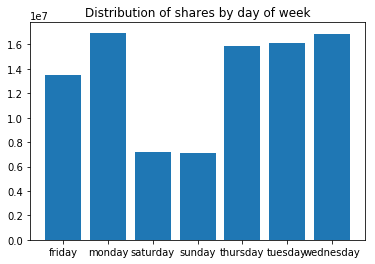

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
weekday_names = [day_of_week_column.replace(" weekday_is_", "") for day_of_week_column in day_of_week_columns]
plt.bar(weekday_names, share_by_weekday)
plt.title("Distribution of shares by day of week")

[5592887, 14892053, 12889454, 6144253, 16071719, 13340303]


Text(0.5,1,'Distribution of shares by channel')

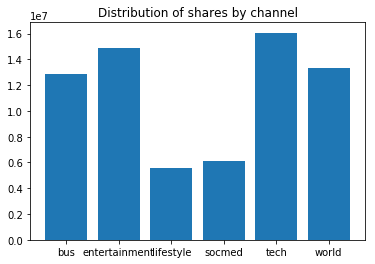

In [5]:
data_channel_columns = [" data_channel_is_lifestyle", " data_channel_is_entertainment", " data_channel_is_bus", " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world"]
share_by_channel = [0]*len(data_channel_columns)

for idx, row in train_df.iterrows():
    for day_no, data_channel_column in enumerate(data_channel_columns):
        if row[data_channel_column] == 1:
            share_by_channel[day_no] += row["shares"]
            
print(share_by_channel)

channel_names = [data_channel_column.replace(" data_channel_is_", "") for data_channel_column in data_channel_columns]
plt.bar(channel_names, share_by_channel)
plt.title("Distribution of shares by channel")

### Train a NN model using neupy

### Approach and code taken from [here](http://neupy.com/apidocs/neupy.algorithms.rbfn.grnn.html) 

In [4]:
training_df = pd.read_csv("data/train_70.0_updated.csv")
training_X = training_df.loc[:, training_df.columns != " shares"]
training_Y = training_df.loc[:, " shares"]

test_df = pd.read_csv("data/test_30_updated.csv")
testing_X = test_df.loc[:, test_df.columns != " shares"]
testing_Y = test_df.loc[:, " shares"]

print("Training shapes")
print(training_X.shape)
print(training_Y.shape)

print("Testing shapes")
print(testing_X.shape)
print(testing_Y.shape)

Training shapes
(27750, 27)
(27750,)
Testing shapes
(11894, 27)
(11894,)


In [5]:
data_scaler = preprocessing.MinMaxScaler()

columns_to_scale = [" n_tokens_title", " n_tokens_content", " num_hrefs", " num_self_hrefs", " num_imgs", " num_videos", " average_token_length", " num_keywords", " kw_avg_min"," kw_avg_max", " kw_avg_avg"," self_reference_avg_sharess"]
training_X.loc[:, columns_to_scale] = data_scaler.fit_transform(training_X.loc[:, columns_to_scale])
training_Y = data_scaler.fit_transform(training_Y.reshape(-1, 1))

testing_X.loc[:, columns_to_scale] = data_scaler.fit_transform(testing_X.loc[:, columns_to_scale])
testing_Y = data_scaler.fit_transform(testing_Y.reshape(-1, 1))

G:\anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
G:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
G:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
G:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [6]:
print(training_X.shape)
print(testing_X.shape)

(27750, 27)
(11894, 27)


### GRNN

### NeuPy imports

In [7]:
from neupy import algorithms, layers, estimators

environment.reproducible()

In [10]:
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(training_X, training_Y)
y_predicted = nw.predict(testing_X)
print(estimators.rmse(y_predicted, testing_Y))

0.016665491935225648


### Invert the target values using [this](https://stackoverflow.com/questions/41551165/invert-minmaxscaler-from-scikit-learn)

In [11]:
y_predicted_upscaled = data_scaler.inverse_transform(y_predicted)
testing_Y_upscaled = data_scaler.inverse_transform(testing_Y)

### Check the predicted values

In [12]:
slice = 100
for itr in range(slice):
    print("#{0}. Diff={1}".format(itr, abs(y_predicted_upscaled[itr] - testing_Y_upscaled[itr])))

#0. Diff=[1290.89548681]
#1. Diff=[944.15984776]
#2. Diff=[16071.0015258]
#3. Diff=[514.39948712]
#4. Diff=[15838.6004488]
#5. Diff=[1154.60599213]
#6. Diff=[3647.21293788]
#7. Diff=[295.10553786]
#8. Diff=[383.55702558]
#9. Diff=[2279.62215478]
#10. Diff=[3493.67788242]
#11. Diff=[3999.95134365]
#12. Diff=[16309.93409339]
#13. Diff=[4580.0040625]
#14. Diff=[1371.68037944]
#15. Diff=[1740.82161519]
#16. Diff=[4229.96199357]
#17. Diff=[560.27674053]
#18. Diff=[1978.80975366]
#19. Diff=[838.72333133]
#20. Diff=[133309.33855459]
#21. Diff=[2008.25303324]
#22. Diff=[2688.78363661]
#23. Diff=[1516.74625832]
#24. Diff=[3699.99755283]
#25. Diff=[2187.78783993]
#26. Diff=[1379.57390628]
#27. Diff=[230.60273462]
#28. Diff=[1214.53274272]
#29. Diff=[817.56162325]
#30. Diff=[2238.60482879]
#31. Diff=[1835.76871171]
#32. Diff=[349.61808355]
#33. Diff=[1641.44742993]
#34. Diff=[101.90641847]
#35. Diff=[73.87574518]
#36. Diff=[1751.02214333]
#37. Diff=[403.23643598]
#38. Diff=[3454.66326129]
#39. Di

### MLFF BP with conjugate gradient

In [13]:
environment.reproducible()
from neupy import algorithms, layers

cgnet = algorithms.ConjugateGradient(
    connection=[
        layers.Input(training_X.shape[1]),
        layers.Sigmoid(50),
        layers.Sigmoid(1),
    ],
    search_method='golden',
    show_epoch=1,
    verbose=True,
    addons=[algorithms.LinearSearch],
)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.49 seconds


#### Note: table below shows MSE - need to take sqrt to get the RMSE


Start training

[TRAINING DATA] shapes: (27750, 27)
[TEST DATA] shapes: (11894, 27)
[TRAINING] Total epochs: 5

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |  0.00025035 |  0.00024234 |       05:44 |
|           2 |  0.00025015 |  0.00024287 |       07:35 |
|           3 |  0.00024959 |  0.00024329 |       07:54 |
|           4 |  0.00024895 |  0.00024192 |       06:54 |
|           5 |  0.00024893 |  0.00024173 |       07:12 |
---------------------------------------------------------



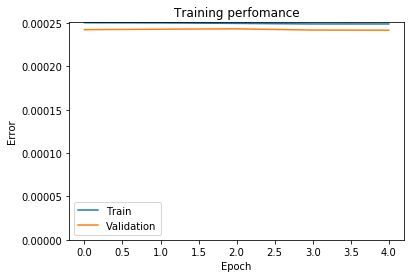

In [14]:
cgnet.train(training_X, training_Y, testing_X, testing_Y, epochs=5)
from neupy import plots
plots.error_plot(cgnet)

In [22]:
from neupy.estimators import rmsle

y_predict = cgnet.predict(testing_X).round(3)

# Root mean square logarithmic error
error = rmsle(data_scaler.inverse_transform(testing_Y), data_scaler.inverse_transform(y_predict))
print(error)

1.2182599245073296


In [23]:
y_predicted_upscaled = data_scaler.inverse_transform(testing_Y)
y_predicted_upscaled = data_scaler.inverse_transform(y_predict)

slice = 100
for itr in range(slice):
    print("#{0}. Diff={1}".format(itr, abs(y_predicted_upscaled[itr] - testing_Y_upscaled[itr])))

#0. Diff=[481.168]
#1. Diff=[2081.168]
#2. Diff=[14318.832]
#3. Diff=[1881.168]
#4. Diff=[1137.876]
#5. Diff=[481.168]
#6. Diff=[2580.168]
#7. Diff=[1224.46]
#8. Diff=[2381.168]
#9. Diff=[3014.168]
#10. Diff=[1318.832]
#11. Diff=[3367.752]
#12. Diff=[14418.832]
#13. Diff=[11045.664]
#14. Diff=[1653.876]
#15. Diff=[2724.46]
#16. Diff=[2332.248]
#17. Diff=[2181.168]
#18. Diff=[2768.168]
#19. Diff=[3460.46]
#20. Diff=[4085.752]
#21. Diff=[618.832]
#22. Diff=[1481.168]
#23. Diff=[1467.752]
#24. Diff=[3967.752]
#25. Diff=[4044.46]
#26. Diff=[2856.168]
#27. Diff=[1337.876]
#28. Diff=[18.832]
#29. Diff=[2669.168]
#30. Diff=[3576.46]
#31. Diff=[3504.46]
#32. Diff=[2524.46]
#33. Diff=[24.46]
#34. Diff=[2181.168]
#35. Diff=[2181.168]
#36. Diff=[3259.46]
#37. Diff=[5254.336]
#38. Diff=[3655.46]
#39. Diff=[2162.124]
#40. Diff=[1638.876]
#41. Diff=[3667.752]
#42. Diff=[3024.46]
#43. Diff=[2653.168]
#44. Diff=[2967.752]
#45. Diff=[1967.752]
#46. Diff=[2232.248]
#47. Diff=[9775.54]
#48. Diff=[2593.16

### SOM using [Neupy](http://neupy.com/apidocs/neupy.algorithms.competitive.sofm.html)

In [10]:
# n_inputs is the number of features

sofm = algorithms.SOFM(n_inputs=27, n_outputs=5, step=0.1, learning_radius=0, verbose=True, grid_type='hexagon')
sofm.train(training_X, epochs=20)
p = sofm.predict(testing_X)


Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] n_inputs = 27
[OPTION] distance = euclid
[OPTION] features_grid = None
[OPTION] grid_type = rect
[OPTION] learning_radius = 0
[OPTION] n_outputs = 5
[OPTION] reduce_radius_after = 100
[OPTION] reduce_std_after = 100
[OPTION] reduce_step_after = 100
[OPTION] std = 1
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (27750, 27)
[TRAINING] Total epochs: 20

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.084664 |           - |       6 sec |
|           2 |    0.084348 |           - |       6 sec |
|           3 |    0.084173 |           - |       6 sec |
|           4 |    0.084016 |           - |       

In [11]:
p

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int64)